# <b>1 <span style='color:#0386f7de'>|</span> Importing libraries</b>
- **For ML Models**: tensorflow, keras
- **For Data Manipulation**: numpy, sklearn
- **For Data Visualization**: matplotlib, seaborn, plotly

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

# <b>2 <span style='color:#0386f7de'>|</span> Reading the Data</b>
#### Here I made two arrays of paths of images with their masks
`all_image_paths` are paths to images and `all_mask_paths` are paths to their respective masks  
So, the image with path `all_images_paths[x]` has a mask with path `all_mask_paths[x]`

In [2]:
# Paths to images
covid_image_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/'
normal_image_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/'
pneumonia_image_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'
lung_opacity_image_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/'

# Paths to masks
covid_mask_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks/'
normal_mask_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/'
pneumonia_mask_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/'
lung_opacity_mask_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks/'

# All paths to images and masks
all_image_paths = [[covid_image_path+file for file in os.listdir(covid_image_path)]
                   +[normal_image_path+file for file in os.listdir(normal_image_path)]
                   +[pneumonia_image_path+file for file in os.listdir(pneumonia_image_path)]
                   +[lung_opacity_image_path+file for file in os.listdir(lung_opacity_image_path)]
                  ][0]
all_mask_paths = [[covid_mask_path+file for file in os.listdir(covid_mask_path)]
                  +[normal_mask_path+file for file in os.listdir(normal_mask_path)]
                  +[pneumonia_mask_path+file for file in os.listdir(pneumonia_mask_path)]
                  +[lung_opacity_mask_path+file for file in os.listdir(lung_opacity_mask_path)]
                 ][0]

# Shuffle the arrays
all_image_paths, all_mask_paths = shuffle(all_image_paths, all_mask_paths)

# <b>3 <span style='color:#0386f7de'>|</span> Visualize Some Samples</b>

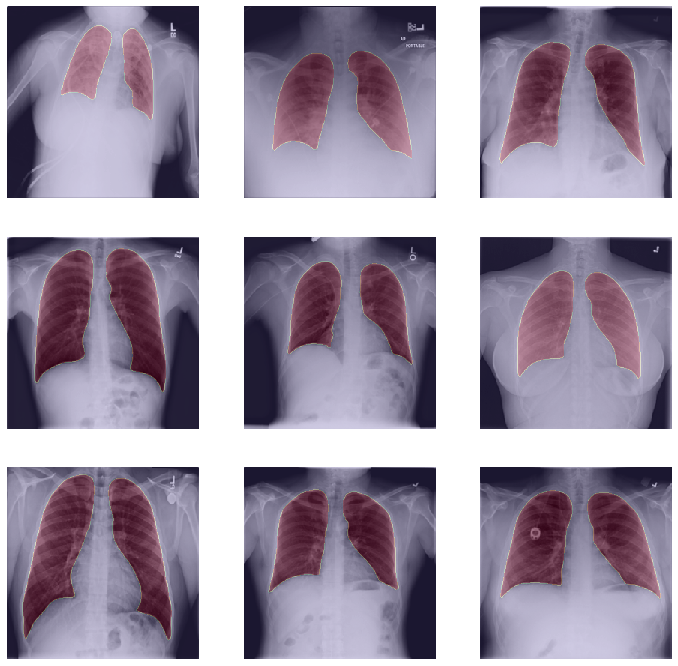

In [3]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c*r +1):
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.imshow(open_images([all_image_paths[i-1]])[0], cmap='gray', interpolation='none')
    plt.imshow(open_images([all_mask_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

# <b>4 <span style='color:#0386f7de'>|</span> Data Generator</b>

In [4]:
print('Total Number of Samples:', len(all_image_paths))

Total Number of Samples: 21165


I will use 17k samples for training and the rest for validation  
This generator function `datagen` returns images with their respective masks as a batch on which the model can train on

In [5]:
train_image_paths = all_image_paths[:17000]
train_mask_paths = all_mask_paths[:17000]
val_image_paths = all_image_paths[17000:]
val_mask_paths = all_mask_paths[17000:]

def datagen(image_paths, mask_paths, batch_size=16):
    for x in range(0, len(image_paths), batch_size):
        images = open_images(image_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        yield images, masks

# <b>5 <span style='color:#0386f7de'>|</span> Model</b>

In [6]:
img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1_pool = MaxPool2D((2,2))(x1)

x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1_pool)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
x2_pool = MaxPool2D((2,2))(x2)

x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x2_pool)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3_pool = MaxPool2D((2,2))(x3)

x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x3_pool)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4_pool = UpSampling2D((2,2))(x4)

x5 = Concatenate()([x4_pool, x3])
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5_pool = UpSampling2D((2,2))(x5)

x6 = Concatenate()([x5_pool, x2])
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6_pool = UpSampling2D((2,2))(x6)

x7 = Concatenate()([x6_pool, x1])
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x7)

model = Model(img_input, x7)

2022-04-26 12:19:15.923817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 12:19:15.928599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 12:19:15.929345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 12:19:15.930598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

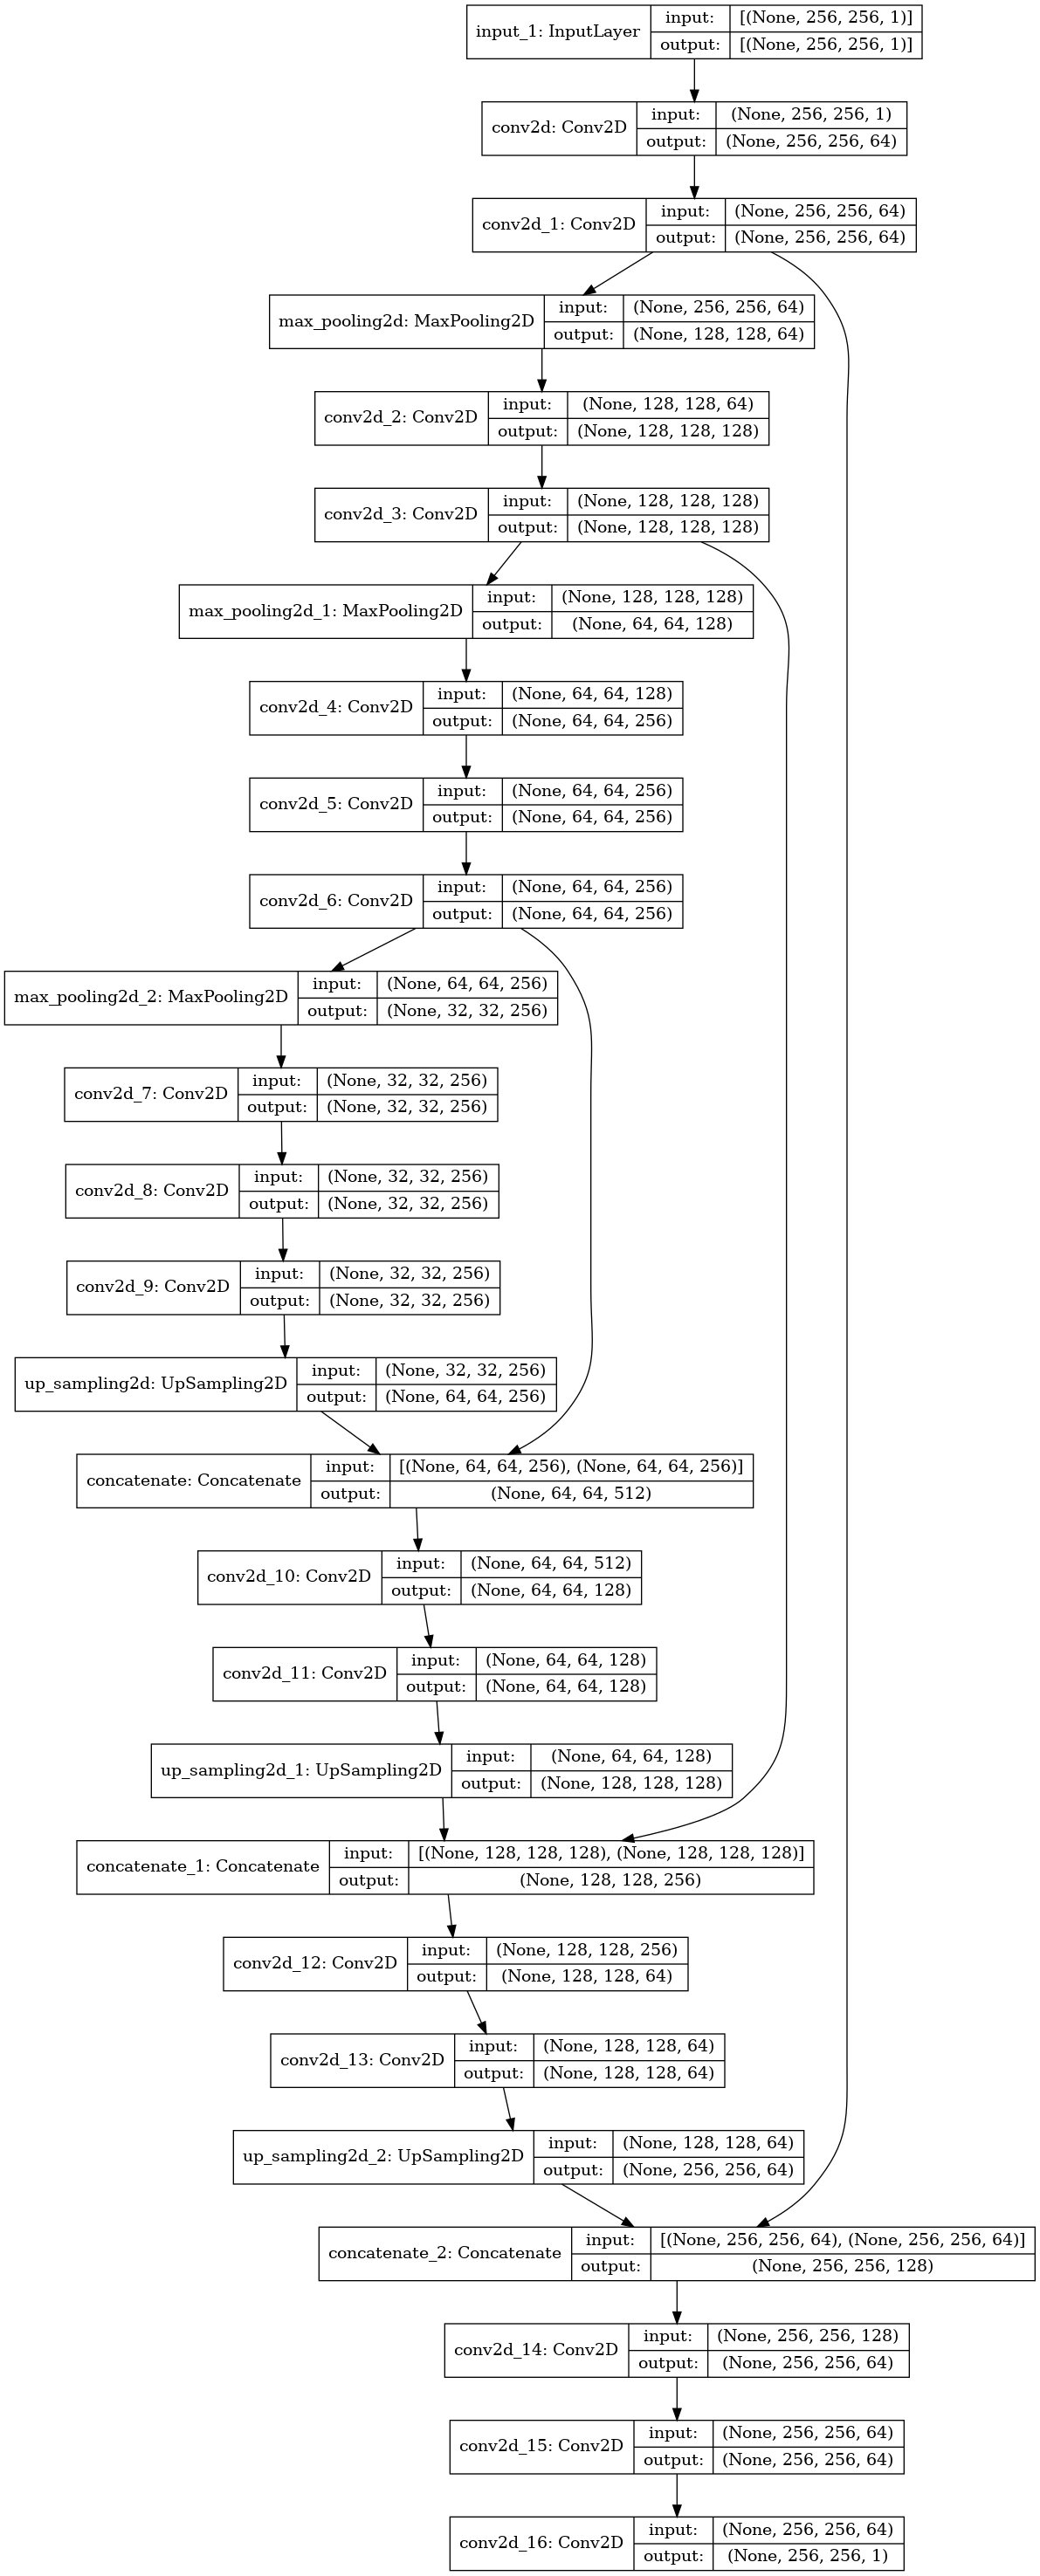

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[iou_coef])

# <b>6 <span style='color:#0386f7de'>|</span> Train Model</b>

In [10]:
batch_size = 20
steps = int(len(train_image_paths)/batch_size)
epochs = 2
for _ in range(epochs):
    model.fit(datagen(train_image_paths, train_mask_paths, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

2022-04-26 12:19:20.037911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 12:19:21.838563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


850/850 [==============================] - 282s 332ms/step - loss: 0.0500 - iou_coef: 0.8816


#### The model achieved 87.3% IoU on training data

# <b>7 <span style='color:#0386f7de'>|</span> Evaluate Model</b>

In [11]:
batch_size = 20
steps = int(len(val_image_paths)/batch_size)
model.evaluate(datagen(val_image_paths, val_mask_paths, batch_size=batch_size), steps=steps)

208/208 [==============================] - 87s 417ms/step - loss: 0.0366 - iou_coef: 0.9124


[0.03662307932972908, 0.9124315977096558]

#### The model achieved 89.9% IoU on validation data

# <b>8 <span style='color:#0386f7de'>|</span> Inference</b>
The `predict` function takes an array of image of shape `(None, IMAGE_SIZE, IMAGE_SIZE, 1)` and returns the predicted mask as an array of the same shape.  
Here, I will round the pixel values of predicted mask to either 0 or 1

In [12]:
def predict(images):
    pred = model.predict(images)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    return pred

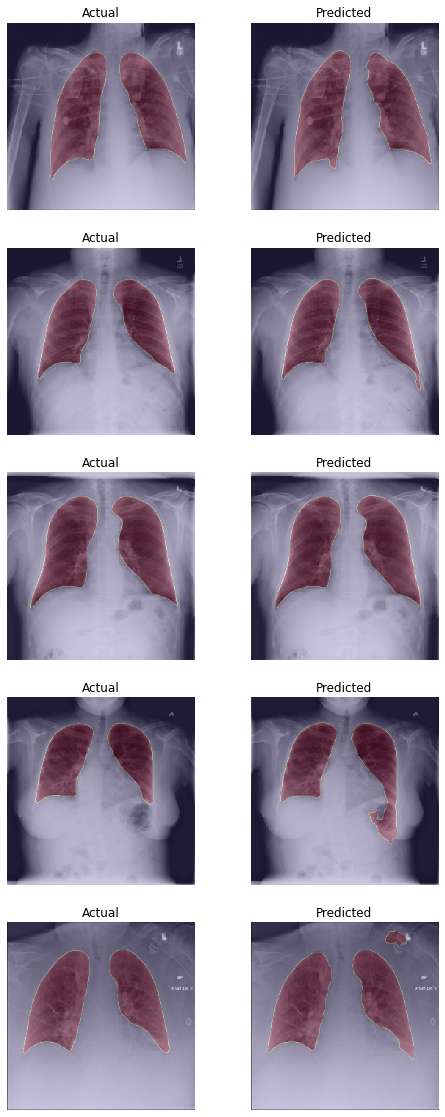

In [13]:
NO_OF_SAMPLES = 5

c = 2
r = NO_OF_SAMPLES
fig = plt.figure(figsize=(8, r*4))
for i in range(1, c*r +1, 2):
    
    image = open_images([val_image_paths[i-1]]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
    mask = open_images([val_mask_paths[i-1]]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
    pred = predict(image)
    
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.title('Actual')
    plt.imshow(image[0], cmap='gray', interpolation='none')
    plt.imshow(mask[0], cmap='Spectral_r', alpha=0.3)
    
    fig.add_subplot(r, c, i+1)
    plt.axis('off')
    plt.title('Predicted')
    plt.imshow(image[0], cmap='gray', interpolation='none')
    plt.imshow(pred[0], cmap='Spectral_r', alpha=0.3)
    
plt.show()

### Please Upvote this notebook as it encourages me in doing better.
![](http://68.media.tumblr.com/e1aed171ded2bd78cc8dc0e73b594eaf/tumblr_o17frv0cdu1u9u459o1_500.gif)